In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets

导入前置操作需要的所有包

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
batch_size = 256  # 批次补充
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

设置GPU，以及训练需要的超参数

In [9]:
image_size = 28
data_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [10]:
train_data = datasets.FashionMNIST(
    root='D:\BaiduNetdiskDownload\FashionMNIST/', train=True, download=False, transform=data_transform)
test_data = datasets.FashionMNIST(
    root='D:\BaiduNetdiskDownload\FashionMNIST/', train=False, download=False, transform=data_transform)

In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

读入数据后，按照设定的参数来载入数据

torch.Size([256, 1, 28, 28]) torch.Size([256])


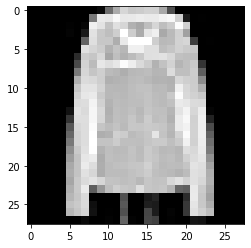

In [12]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

In [13]:
#设计神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [17]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [18]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.656190
Epoch: 1 	Validation Loss: 0.413230, Accuracy: 0.852000
Epoch: 2 	Training Loss: 0.415757
Epoch: 2 	Validation Loss: 0.335658, Accuracy: 0.879800
Epoch: 3 	Training Loss: 0.354025
Epoch: 3 	Validation Loss: 0.292145, Accuracy: 0.892500
Epoch: 4 	Training Loss: 0.324797
Epoch: 4 	Validation Loss: 0.272536, Accuracy: 0.898900
Epoch: 5 	Training Loss: 0.301305
Epoch: 5 	Validation Loss: 0.276038, Accuracy: 0.897700
Epoch: 6 	Training Loss: 0.284770
Epoch: 6 	Validation Loss: 0.252385, Accuracy: 0.905300
Epoch: 7 	Training Loss: 0.272588
Epoch: 7 	Validation Loss: 0.243967, Accuracy: 0.910200
Epoch: 8 	Training Loss: 0.258514
Epoch: 8 	Validation Loss: 0.234251, Accuracy: 0.912000
Epoch: 9 	Training Loss: 0.249231
Epoch: 9 	Validation Loss: 0.232444, Accuracy: 0.915000
Epoch: 10 	Training Loss: 0.237940
Epoch: 10 	Validation Loss: 0.229074, Accuracy: 0.916500
Epoch: 11 	Training Loss: 0.234217
Epoch: 11 	Validation Loss: 0.217144, Accuracy: 0.920100
Epoch:

In [19]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)